# Statistical Threshold Model (Baseline)
Basic univariate detection with statistical quantile thresholds.

In [0]:
import pandas as pd
import math

import json

# Matplotlib for visualization at the end
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, when, lit, udf, current_date, date_sub
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

In [0]:
# Load selected features
feature_cols_json = dbutils.fs.head("dbfs:/tmp/feature_cols.json")
feature_cols = json.loads(feature_cols_json)
feature_cols

Out[2]: ['temperature_2m', 'precipitation', 'wind_gusts_10m', 'cloud_cover']

In [0]:
# Load data from DBFS
sdf = spark.table("historical_weather_hourly_lisbon")
display(sdf.limit(10))

time,temperature_2m,precipitation,wind_gusts_10m,cloud_cover,features,features_scaled
2025-03-02T12:00,11.9,0.0,35.6,100.0,"Map(vectorType -> dense, length -> 4, values -> List(11.9, 0.0, 35.6, 100.0))","Map(vectorType -> dense, length -> 4, values -> List(-1.0715630887496022, -0.2045818640908716, 0.9129135165605267, 1.1864919785095578))"
2025-03-02T13:00,12.8,0.0,33.5,97.0,"Map(vectorType -> dense, length -> 4, values -> List(12.8, 0.0, 33.5, 97.0))","Map(vectorType -> dense, length -> 4, values -> List(-0.8981816211481713, -0.2045818640908716, 0.7568701329712245, 1.1096330649379178))"
2025-03-02T14:00,13.5,0.0,29.2,91.0,"Map(vectorType -> dense, length -> 4, values -> List(13.5, 0.0, 29.2, 91.0))","Map(vectorType -> dense, length -> 4, values -> List(-0.7633293685692809, -0.2045818640908716, 0.43735272847884427, 0.9559152377946378))"
2025-03-02T15:00,13.1,0.0,31.0,92.0,"Map(vectorType -> dense, length -> 4, values -> List(13.1, 0.0, 31.0, 92.0))","Map(vectorType -> dense, length -> 4, values -> List(-0.8403877986143613, -0.2045818640908716, 0.5711042001268174, 0.9815348756518512))"
2025-03-02T16:00,12.9,0.3,32.8,95.0,"Map(vectorType -> dense, length -> 4, values -> List(12.9, 0.3, 32.8, 95.0))","Map(vectorType -> dense, length -> 4, values -> List(-0.8789170136369013, 0.6885826956378645, 0.7048556717747904, 1.0583937892234911))"
2025-03-02T17:00,12.4,0.4,33.1,93.0,"Map(vectorType -> dense, length -> 4, values -> List(12.4, 0.4, 33.1, 93.0))","Map(vectorType -> dense, length -> 4, values -> List(-0.9752400511932517, 0.9863042155474432, 0.7271475837161195, 1.0071545135090645))"
2025-03-02T18:00,11.8,0.0,33.1,88.0,"Map(vectorType -> dense, length -> 4, values -> List(11.8, 0.0, 33.1, 88.0))","Map(vectorType -> dense, length -> 4, values -> List(-1.0908276962608723, -0.2045818640908716, 0.7271475837161195, 0.879056324222998))"
2025-03-02T19:00,11.3,0.0,31.3,86.0,"Map(vectorType -> dense, length -> 4, values -> List(11.3, 0.0, 31.3, 86.0))","Map(vectorType -> dense, length -> 4, values -> List(-1.1871507338172227, -0.2045818640908716, 0.5933961120681464, 0.8278170485085713))"
2025-03-02T20:00,11.0,0.0,29.5,84.0,"Map(vectorType -> dense, length -> 4, values -> List(11.0, 0.0, 29.5, 84.0))","Map(vectorType -> dense, length -> 4, values -> List(-1.244944556351033, -0.2045818640908716, 0.45964464042017317, 0.7765777727941446))"
2025-03-02T21:00,10.6,0.0,28.8,73.0,"Map(vectorType -> dense, length -> 4, values -> List(10.6, 0.0, 28.8, 73.0))","Map(vectorType -> dense, length -> 4, values -> List(-1.3220029863961136, -0.2045818640908716, 0.40763017922373923, 0.494761756364798))"


In [0]:
# Threshold list builder
lower_q = 0.015
upper_q = 0.985

threshold_data = []

for feature in feature_cols:
    q_low, q_high = sdf.approxQuantile(feature, [lower_q, upper_q], 0.01)
    threshold_data.append((feature, float(q_low), float(q_high)))

schema = StructType([
    StructField("feature", StringType(), False),
    StructField("lower_threshold", DoubleType(), False),
    StructField("upper_threshold", DoubleType(), False)
])

threshold_sdf = spark.createDataFrame(threshold_data, schema)

# Save threshold list
# threshold_df.write.format("delta").mode("overwrite").save("/tmp/quantile_threshold_model")
# threshold_df.write.format("parquet").mode("overwrite").saveAsTable("quantile_thresholds")

display(threshold_sdf)


feature,lower_threshold,upper_threshold
temperature_2m,7.4,31.0
precipitation,0.0,1.1
wind_gusts_10m,2.5,56.2
cloud_cover,0.0,100.0


### Apply basic threshold model to training historical dataset

In [0]:
sdf_flagged = sdf

for row in threshold_data:
    feature, low, high = row
    sdf_flagged = sdf_flagged.withColumn(
        f"{feature}_anomaly",
        when((col(feature) < lit(low)) | (col(feature) > lit(high)), 1).otherwise(0)
    )

## Visualization for the historic year

In [0]:
# Filter dataframe for last 45 days
previous_date = date_sub(current_date(), 45)
filtered_sdf = sdf_flagged.filter(col("time") >= previous_date)

# Select needed columns
plot_df = filtered_sdf.select(
    "time",
    "temperature_2m",
    "wind_gusts_10m",
    "precipitation",
    "cloud_cover",
    "temperature_2m_anomaly",
    "wind_gusts_10m_anomaly",
    "precipitation_anomaly",
    "cloud_cover_anomaly"
).orderBy("time").toPandas()

# Extract first and last time points
first_time = plot_df["time"].iloc[0]
last_time = plot_df["time"].iloc[-1]

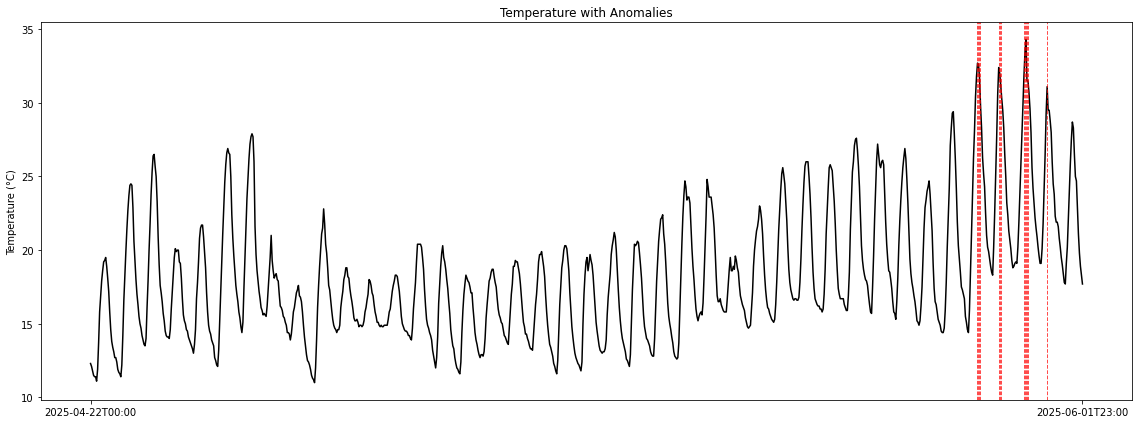

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["temperature_2m"], color="black", label="Temperature (°C)")
ax1.set_ylabel("Temperature (°C)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_xticks([first_time, last_time])
ax1.set_xticklabels([first_time, last_time])

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["temperature_2m_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Title and legend
plt.title("Temperature with Anomalies")
fig.tight_layout()
plt.show()

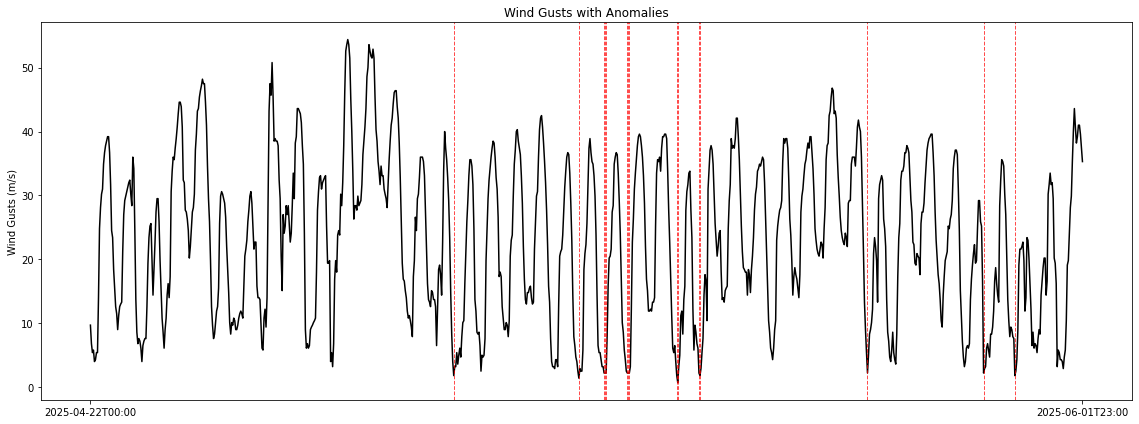

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["wind_gusts_10m"], color="black", label="Wind Gusts (m/s)")
ax1.set_ylabel("Wind Gusts (m/s)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_xticks([first_time, last_time])
ax1.set_xticklabels([first_time, last_time])

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["wind_gusts_10m_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Title and legend
plt.title("Wind Gusts with Anomalies")
fig.tight_layout()
plt.show()

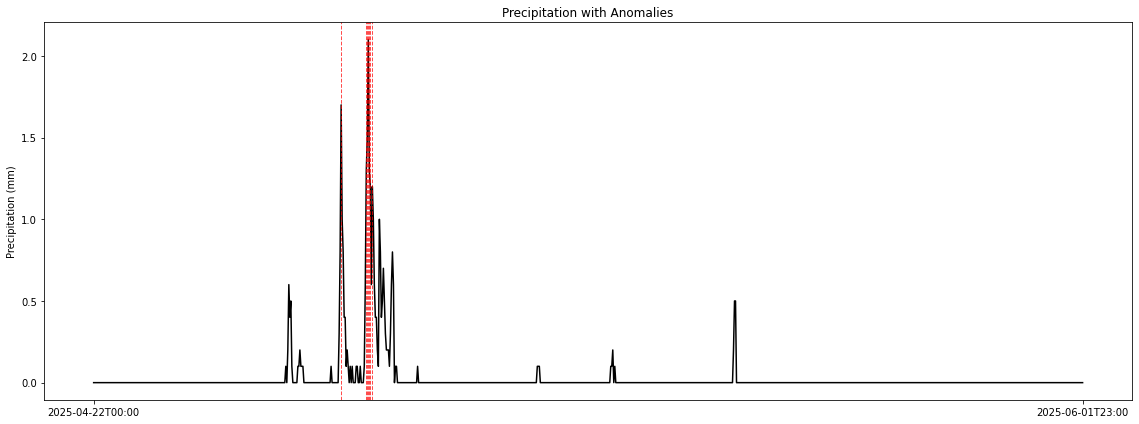

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["precipitation"], color="black", label="Precipitation (mm)")
ax1.set_ylabel("Precipitation (mm)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_xticks([first_time, last_time])
ax1.set_xticklabels([first_time, last_time])

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["precipitation_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Title and legend
plt.title("Precipitation with Anomalies")
fig.tight_layout()
plt.show()

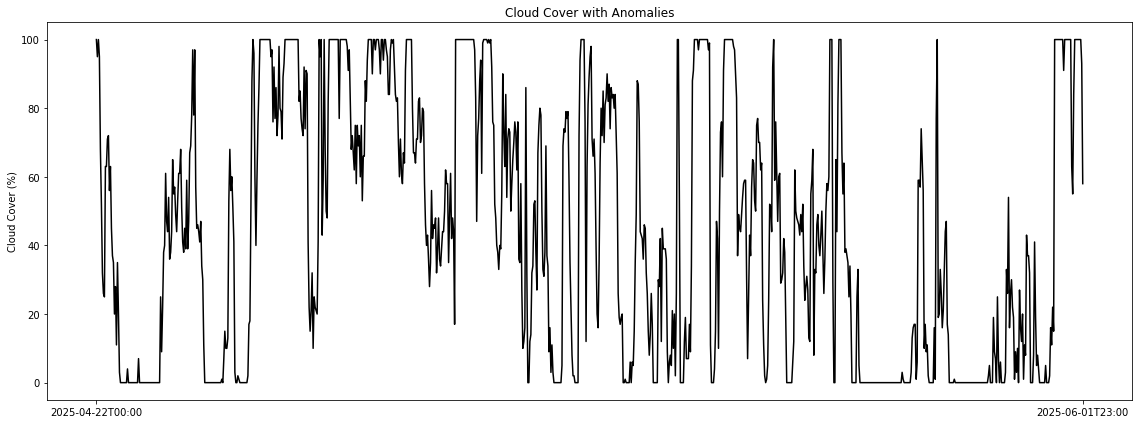

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["cloud_cover"], color="black", label="Cloud Cover (%)")
ax1.set_ylabel("Cloud Cover (%)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_xticks([first_time, last_time])
ax1.set_xticklabels([first_time, last_time])

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["cloud_cover_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Title and legend
plt.title("Cloud Cover with Anomalies")
fig.tight_layout()
plt.show()